In [1]:
!pip install statsmodels -U

     |████████████████████████████████| 9.5MB 6.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import psycopg2
import pandas as pd

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
conn = psycopg2.connect(host="51.38.226.135", port = 55432, database="real_estate_db", user="brawl_stars", password="jRTXZecDQbpRuVy97g9a")

In [4]:
def postgresql_to_dataframe(conn, select_query, column_names):
    cursor = conn.cursor()
    cursor.execute(select_query)
    tupples = cursor.fetchall()
    cursor.close()
    df = pd.DataFrame(tupples, columns=column_names)
    return df

In [5]:
purchases_column_names = ["property_id", "purchase_price", "date_purchased"]
sells_column_names = ["property_id", "sell_price", "date_sold"]

In [6]:
purchases = postgresql_to_dataframe(conn, "select * from purchases", purchases_column_names)
sells = postgresql_to_dataframe(conn, "select * from sells", sells_column_names)

In [7]:
data = pd.merge(purchases, sells, on="property_id")

In [8]:
data["profit"] = data["sell_price"] - data["purchase_price"]
data.drop(['property_id', 'date_purchased', 'sell_price', 'purchase_price'], axis=1, inplace=True)
data

,date_sold,profit
0,2006-01-12,31500
1,2007-01-21,85500
2,2007-02-16,50000
3,2007-02-22,84000
4,2007-02-27,75400
...,...,...
41118,2019-09-21,49000
41119,2019-09-23,27500
41120,2019-09-23,10950
41121,2019-09-23,41600


In [9]:
data['date_sold'] = pd.to_datetime(data['date_sold'])
data_ts = data.resample('M', on='date_sold').mean()
data_ts.fillna(0, inplace=True)

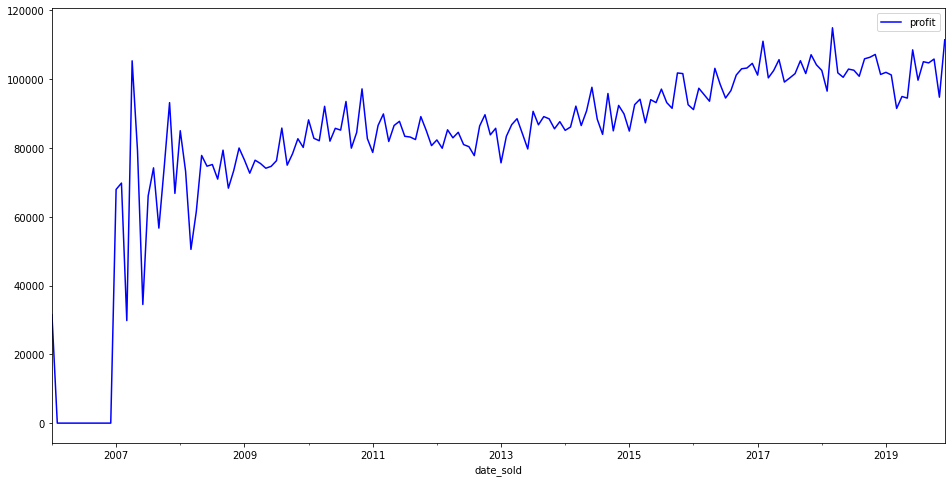

In [10]:
import matplotlib
import matplotlib.pyplot as plt

data_ts.plot(figsize=(16,8), color='blue')

plt.show()

In [11]:
import itertools
import numpy as np
import statsmodels.api as sm

In [12]:
from statsmodels.tsa.stattools import adfuller

ts = data_ts['profit']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.01:
    print('Наш ряд стационарный')
    print('p-value:', st_test[1])
else:
    print('Ряд нестационарный')

Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный
p-value: 5.976999522495662e-07


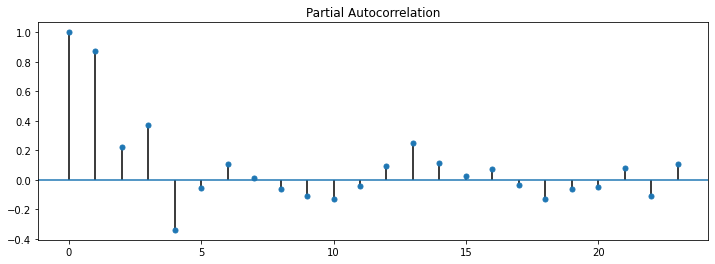

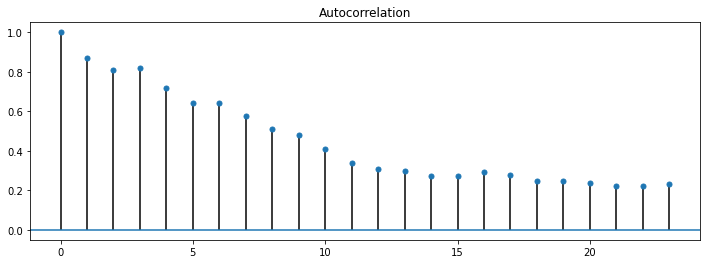

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
ts = data_ts['profit']
plot_pacf(ts, alpha=None).set_size_inches(12, 4)
plt.show()

plot_acf(ts, alpha=None).set_size_inches(12, 4)
plt.show()


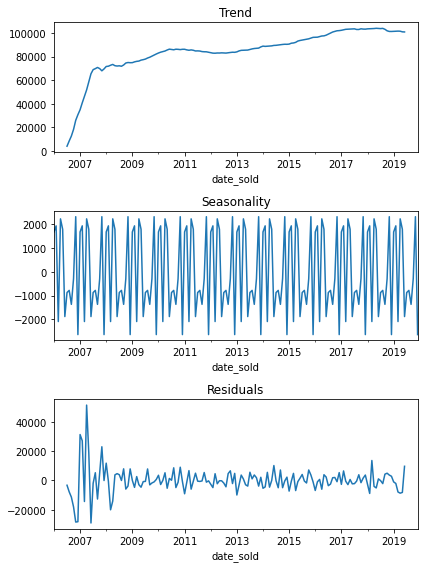

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(ts)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

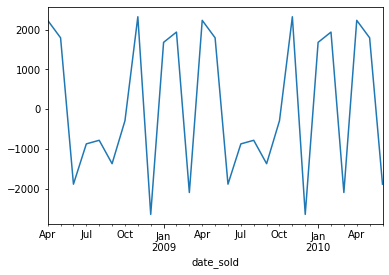

In [15]:
decomposed.seasonal['2008-04-01':'2010-06-30'].plot(ax=plt.gca())

In [16]:
mod = sm.tsa.statespace.SARIMAX(data_ts,
order=(1, 1, 1),
seasonal_order=(1, 1, 1, 12),
enforce_stationarity=False,
enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0782      0.352     -0.222      0.824      -0.769       0.613
ma.L1         -0.6066      0.212     -2.863      0.004      -1.022      -0.191
ar.S.L12      -0.0206      0.170     -0.121      0.903      -0.353       0.312
ma.S.L12      -0.7525      0.132     -5.696      0.000      -1.011      -0.494
sigma2      1.783e+08   2.21e-10   8.07e+17      0.000    1.78e+08    1.78e+08


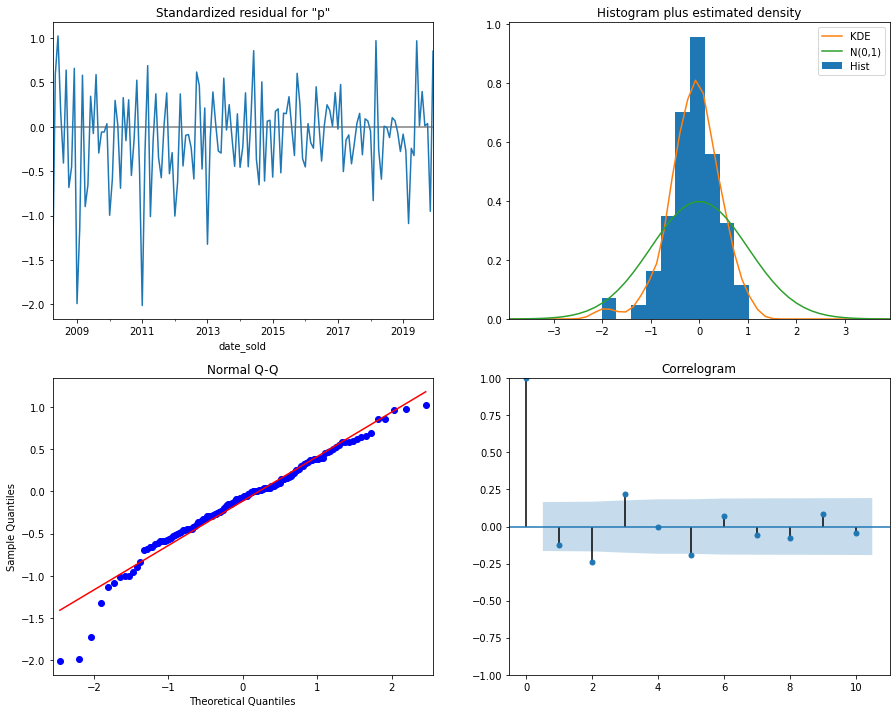

In [17]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [18]:
data_ts

,profit
date_sold,
2006-01-31,31500.000000
2006-02-28,0.000000
2006-03-31,0.000000
2006-04-30,0.000000
2006-05-31,0.000000
...,...
2019-08-31,105085.306358
2019-09-30,104746.855895
2019-10-31,105866.932432


In [19]:
pred = results.get_prediction(start=100, dynamic=False)
pred_ci = pred.conf_int()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [21]:
data_ts[100:].profit

date_sold
2014-05-31     90781.919643
2014-06-30     97660.176271
2014-07-31     88374.586667
2014-08-31     83971.474916
2014-09-30     95847.992453
                  ...      
2019-08-31    105085.306358
2019-09-30    104746.855895
2019-10-31    105866.932432
2019-11-30     94778.548387
2019-12-31    111470.925234
Freq: M, Name: profit, Length: 68, dtype: float64

In [22]:
pred.predicted_mean

date_sold
2014-05-31     89484.127393
2014-06-30     86202.686574
2014-07-31     93225.571846
2014-08-31     92687.039753
2014-09-30     89078.671973
                  ...      
2019-08-31     99769.657225
2019-09-30    104589.432445
2019-10-31    105369.281108
2019-11-30    107481.117525
2019-12-31    100074.149668
Freq: M, Name: predicted_mean, Length: 68, dtype: float64

In [23]:
mean_squared_error(pred.predicted_mean, data_ts[100:].profit) ** 0.5

5492.731072567888

In [25]:
mean_absolute_error(pred.predicted_mean, data_ts[100:].profit)

4048.0454231046615

In [26]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

smape(pred.predicted_mean, data_ts[100:].profit)

4.111559426817772

In [27]:
from statsmodels.tsa.arima.model import ARIMA
model_arma = ARIMA(ts, order=(1,1,1)).fit()
print(model_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                 profit   No. Observations:                  168
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1784.936
Date:                Sat, 22 May 2021   AIC                           3575.873
Time:                        21:20:48   BIC                           3585.227
Sample:                    01-31-2006   HQIC                          3579.669
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0369      0.048     -0.762      0.446      -0.132       0.058
ma.L1         -0.5354      0.039    -13.853      0.000      -0.611      -0.460
sigma2      1.266e+08   2.17e-10   5.84e+17      0.0

In [28]:
pred_arma = model_arma.get_prediction(start=100, dynamic=False)

In [29]:
smape(pred_arma.predicted_mean, data_ts[100:].profit)

4.197319289264971

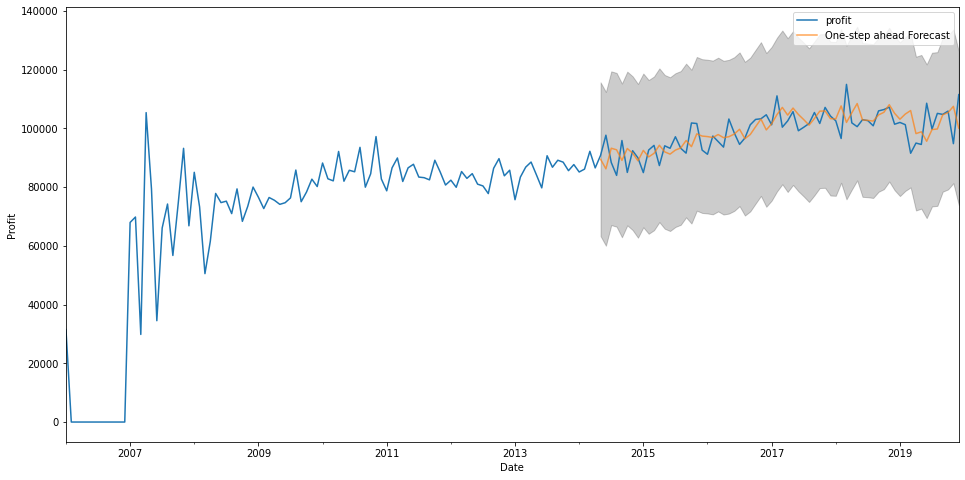

In [30]:
ax = data_ts['2006':].plot(figsize=(16,8),label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Profit')
plt.legend()
plt.show()

In [35]:
pred_uc = results.get_forecast(steps=25)
pred_ci = pred_uc.conf_int()

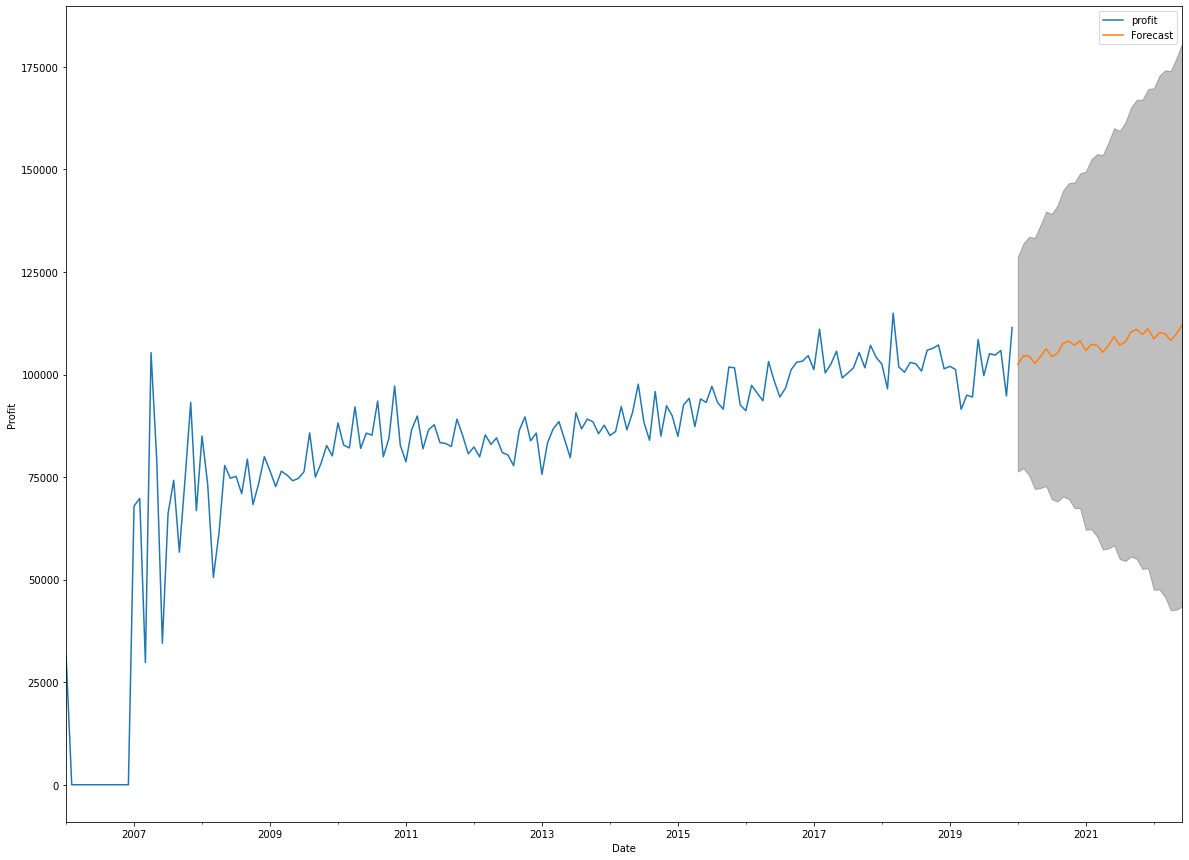

In [34]:
ax = data_ts.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Profit')
plt.legend()
plt.show()